In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import weakref
import copy
import time
import gc
import datetime
import argparse
import logging
import glob
import numpy as np
import json, cv2, random
import matplotlib.pyplot as plt
from collections import Counter
from typing import Dict, List, Optional
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import astropy_mpl_style
from fvcore.common.param_scheduler import ParamScheduler
from collections import OrderedDict
from fvcore.nn.precise_bn import get_bn_modules
from omegaconf import OmegaConf
from scipy.ndimage import gaussian_filter
from torch.nn.parallel import DistributedDataParallel

# import detectron2 utilities
import detectron2
import detectron2.data as data
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.utils.comm as comm
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2 import model_zoo
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.solver import LRMultiplier
from detectron2.solver import LRScheduler as _LRScheduler
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from detectron2.engine.hooks import LRScheduler
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.events import EventStorage, get_event_storage
from detectron2.utils.logger import log_every_n_seconds
from detectron2.utils.logger import setup_logger

setup_logger()
dataset_sets = ['train', 'test', 'validate']
nn = '_z.fits'
output_name = 'model'

In [ ]:
#################################################################################################
directory = '/content/drive/MyDrive/Colab Notebooks/IKI projects/Data/Detection'
output = '/content/drive/MyDrive/Colab Notebooks/IKI projects/Data/Detection/weight'
#################################################################################################

**Loading and logging data**

In [ ]:
def dataset_markup(folder):

    dataset_markups = []
    sets = sorted(glob.glob('%s/set_*' % folder))

    for idx, sets in enumerate(sets):
        instance = {}

        markup = os.path.join(folder, sets, "markup.txt")
        filename = os.path.join(folder, sets, "img")

        with open(markup) as f:
          instance = json.load(f)
        instance["file_name"] = filename

        for i in range(len(instance["annotations"])):
          instance["annotations"][i]['category_id'] = 0
        dataset_markups.append(instance)

    return dataset_markups

dataset_markups = {}
for i, j in enumerate(dataset_sets):
    sets_dir = os.path.join(directory,j)
    DatasetCatalog.register("data_" + j, lambda: dataset_markup(sets_dir))
    MetadataCatalog.get("data_" + j).set(thing_classes=[''], things_colors = ['black'])
    dataset_markups[j] = dataset_markup(os.path.join(directory, j))
metadata = MetadataCatalog.get("data_train")

In [ ]:
def apply_clahe(image, clip_limit=4.0, tile_grid_size=(10, 10)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_image = clahe.apply(image)
    clahe_image = clahe_image.astype(np.uint8)
    clahe_image = np.expand_dims(clahe_image, axis = 2)
    return clahe_image

def normalization(image_path, gauss=False, gauss_sigma=1, clahe=False, clahe_clip_limit=4.0, eps=10**-5):

    image = fits.getdata(os.path.join(image_path+nn), memmap=False)
    len, wid = image.shape
    img = np.empty([len, wid, 1], dtype=np.uint8)
    image = np.nan_to_num(np.log10(image-np.amin(image)+eps), neginf=eps)

    if gauss:
      image = gaussian_filter(image, sigma=gauss_sigma)

    max_im = np.amax(image)
    max_dtype = np.iinfo(np.uint8).max
    coeff = max_dtype/max_im
    image *= coeff
    img[:,:,0] = image

    if clahe:
      img = apply_clahe(img, clip_limit=clahe_clip_limit)
    return img

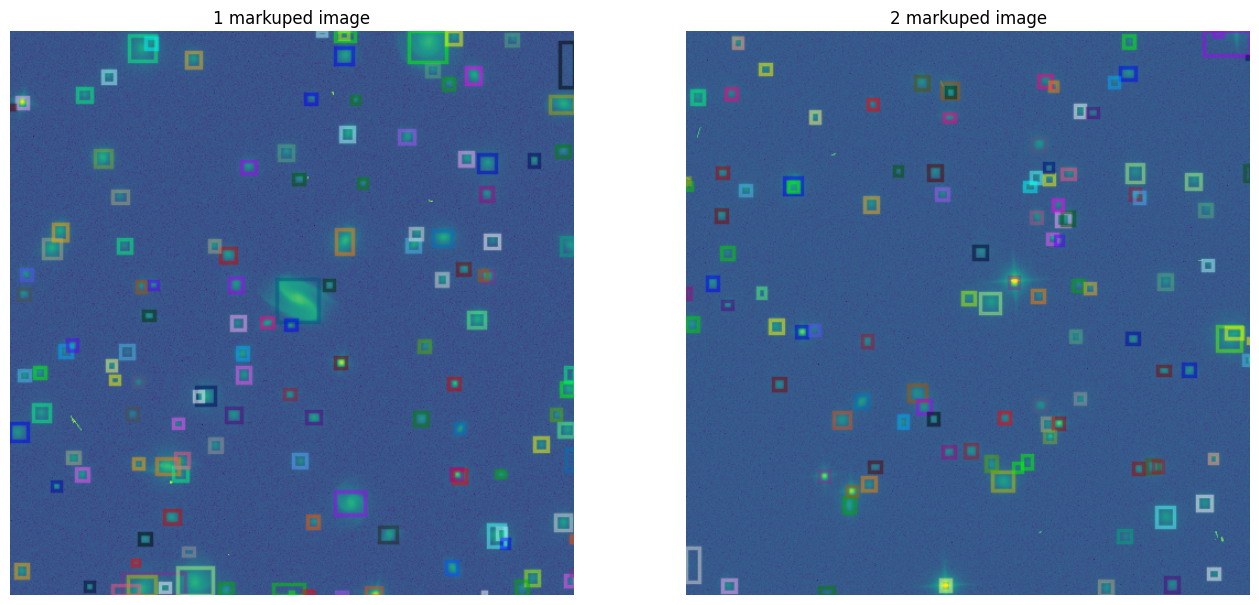

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for i, j in enumerate(random.sample(dataset_markups['train'], 2)):
    img = normalization(j["file_name"])
    visualizer = Visualizer(img, metadata=metadata)

    gt_boxes = np.array([a['bbox'] for a in j['annotations']])
    gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
    out = visualizer.overlay_instances(boxes=gt_boxes)
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    axs[i].set_title(f"{i+1} markuped image")

**Base classes for training**

In [ ]:
class SaveHook(HookBase):
    def model_name(self, name):
        self.output_name = name
    def after_train(self):
        self.trainer.checkpointer.save(self.output_name)


#https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b
#Add self.trainer.add_val_loss(mean_loss) and change logging info printer
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        self.trainer.add_val_loss(mean_loss)
        print(f'Validate loss: {round(mean_loss, 4)}')
        comm.synchronize()
        return losses

    def _get_loss(self, data):
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
class Mapper:
    def __init__(self,**read_image_args):
        self.ria = read_image_args

    def __call__(self,dataset_markups):
        dataset_markups = copy.deepcopy(dataset_markups)
        image = normalization(dataset_markups["file_name"])

        augs = T.AugmentationList([
        T.RandomFlip(prob=0.5),
        T.Resize((512,512))
        ])

        # Augmentation
        auginput = T.AugInput(image)
        transform = augs(auginput)
        image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
        annos = [
            utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
            for annotation in dataset_markups.pop("annotations")
        ]
        return {
            "image": image,
            "image_shaped": auginput.image,
            "height": 512,
            "width": 512,
            "image_id": dataset_markups["image_id"],
            "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        }

class Training(SimpleTrainer):
    def __init__(self, model, data_loader, optimizer, cfg):
        super().__init__(model, data_loader, optimizer)
        self.checkpointer = checkpointer.DetectionCheckpointer(
            model,
            cfg.OUTPUT_DIR
        )
        self.checkpointer.load(cfg.MODEL.WEIGHTS)

        self.lossList = []
        self.vallossList = []

        self.period = 20
        self.iterCount = 0

        self.scheduler = self.build_lr_scheduler(cfg, optimizer)
        self.valloss=0

    def set_period(self,p):
        self.period = p

    def run_step(self):
        self.iterCount = self.iterCount + 1
        assert self.model.training, "Model was changed to eval mode!"
        start = time.perf_counter()
        data_time = time.perf_counter() - start
        data = next(self._data_loader_iter)
        loss_dict = self.model(data)
        if isinstance(loss_dict, torch.Tensor):
            losses = loss_dict
            loss_dict = {"total_loss": loss_dict}
        else:
            losses = sum(loss_dict.values())
        self.optimizer.zero_grad()
        losses.backward()
        self.optimizer.step()

        self.lossList.append(losses.cpu().detach().numpy())
        if self.iterCount % self.period == 0 and comm.is_main_process():
            print("iteration: ", self.iterCount," loss: ",np.round(losses.cpu().detach().numpy(),4))

        del data
        gc.collect()
        torch.cuda.empty_cache()

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)


    def add_val_loss(self,val_loss):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """

        self.vallossList.append(val_loss)

**Training with the following parameters:**

1. epoch = 200 iteration
2. iteration = 5 image with 512*512 shape
3. first stage of training includes 8 epochs with freezing backbone at 3
4. second stage of training includes 16 epochs with unfreeze backbone and learning rate decay



In [ ]:
cfg = get_cfg()
COCO = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(COCO))

epoch = 200
max_iter_1 = 8*epoch
max_iter_2 = 16*epoch

cfg.DATASETS.TRAIN = ("data_train")
cfg.DATASETS.TEST = ("data_validate")
cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 250
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512
cfg.INPUT.MIN_SIZE_TRAIN = 512
cfg.INPUT.MAX_SIZE_TRAIN = 512
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4, 8, 16, 32, 64]]
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.OUTPUT_DIR = output
cfg.TEST.DETECTIONS_PER_IMAGE = 10000
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 4.0

cfg.MODEL.BACKBONE.FREEZE_AT = 3
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.STEPS = []
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.MAX_ITER = max_iter_1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(COCO)
_mapper = Mapper()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)

loader = data.build_detection_train_loader(cfg, mapper=_mapper)
test_loader = data.build_detection_test_loader(cfg,cfg.DATASETS.TEST, mapper=_mapper)

saveHook = SaveHook()
saveHook.model_name(output_name)
schedulerHook = LRScheduler(optimizer=optimizer)
lossHook = LossEvalHook(2*epoch, model, test_loader)
hookList = [lossHook,schedulerHook,saveHook]

trainer = Training(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(epoch/2)
trainer.train(0,max_iter_1)

# 2nd part with decay lr

cfg.MODEL.BACKBONE.FREEZE_AT = 0  # unfreeze
cfg.SOLVER.BASE_LR = 0.0005
cfg.SOLVER.STEPS = [6*epoch,10*epoch]
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.MAX_ITER = max_iter_2
cfg.MODEL.WEIGHTS = os.path.join(output, output_name+'.pth')

model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=_mapper)
test_loader = data.build_detection_test_loader(cfg,cfg.DATASETS.TEST, mapper=_mapper)

saveHook = SaveHook()
saveHook.model_name(output_name)
schedulerHook = LRScheduler(optimizer=optimizer)
lossHook = LossEvalHook(2*epoch, model, test_loader)
hookList = [lossHook,schedulerHook,saveHook]

trainer = Training(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(epoch/2)
trainer.train(0,max_iter_2)

[06/14 07:06:02 d2.data.build]: Using training sampler TrainingSampler
[06/14 07:06:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 07:06:02 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[06/14 07:06:02 d2.data.common]: Serialized dataset takes 4.07 MiB
[06/14 07:06:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 07:06:03 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[06/14 07:06:03 d2.data.common]: Serialized dataset takes 4.07 MiB
[06/14 07:06:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl ...


model_final_2d9806.pkl: 431MB [00:05, 85.8MB/s]                           
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/14 07:06:08 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


iteration:  100  loss:  1.4077
iteration:  200  loss:  1.1971
iteration:  300  loss:  1.1581
iteration:  400  loss:  1.0842
Validate loss: 1.1132
iteration:  500  loss:  1.1091
iteration:  600  loss:  1.051
iteration:  700  loss:  0.9823
iteration:  800  loss:  1.0158
Validate loss: 1.0045
iteration:  900  loss:  0.993
iteration:  1000  loss:  0.9957
iteration:  1100  loss:  0.9778
iteration:  1200  loss:  0.9704
Validate loss: 0.9532
iteration:  1300  loss:  1.072
iteration:  1400  loss:  0.9517
iteration:  1500  loss:  0.9497
iteration:  1600  loss:  0.9184
Validate loss: 0.9195
[06/14 08:11:04 d2.data.build]: Removed 0 images with no usable annotations. 250 images left.
[06/14 08:11:04 d2.data.build]: Using training sampler TrainingSampler
[06/14 08:11:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 08:11:04 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[06/14 08:11:04 d2.data.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.7 # boxes overlap threshold
predictor = DefaultPredictor(cfg)

[06/14 10:24:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Colab Notebooks/IKI projects/Data/Detection/weight/model.pth ...


**Example detection on a test set**

1 image:
true: 164
predicted: 151

2 image:
true: 139
predicted: 125



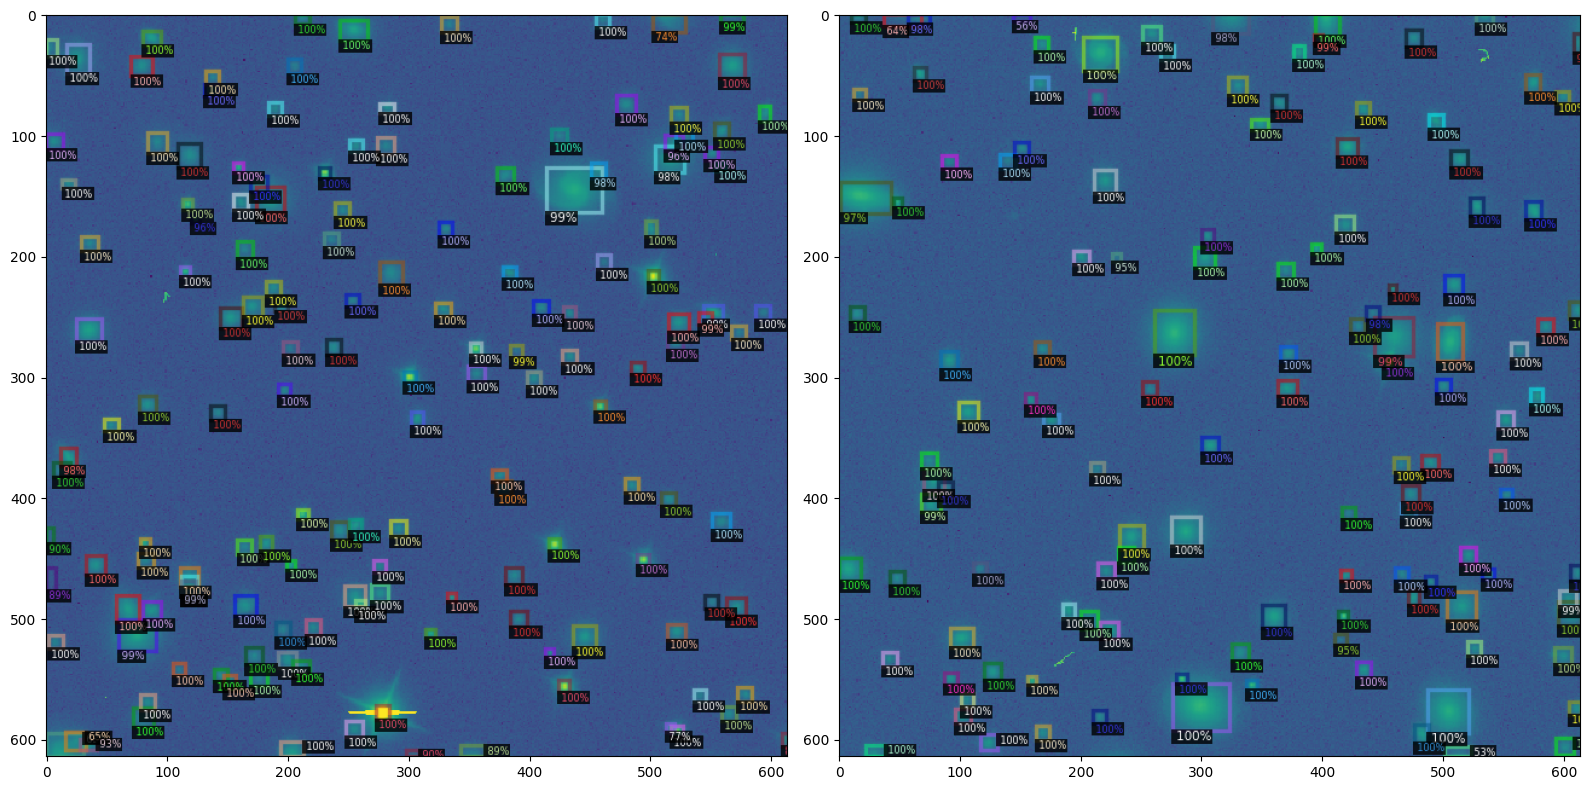

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for i, j in enumerate(random.sample(dataset_markups['test'], 2)):
    img = normalization(j["file_name"])
    outputs = predictor(img)
    print(f"{i+1} image:")
    print('true:', len(j['annotations']))
    print('predicted:', len(outputs['instances'].pred_boxes))
    print('')
    outputs["instances"].pred_masks = torch.zeros_like(outputs["instances"].pred_masks)

    v = Visualizer(img,
                   metadata=metadata,
                   scale=1.2,
                   instance_mode=ColorMode#.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    fig.tight_layout()
    fig.show();

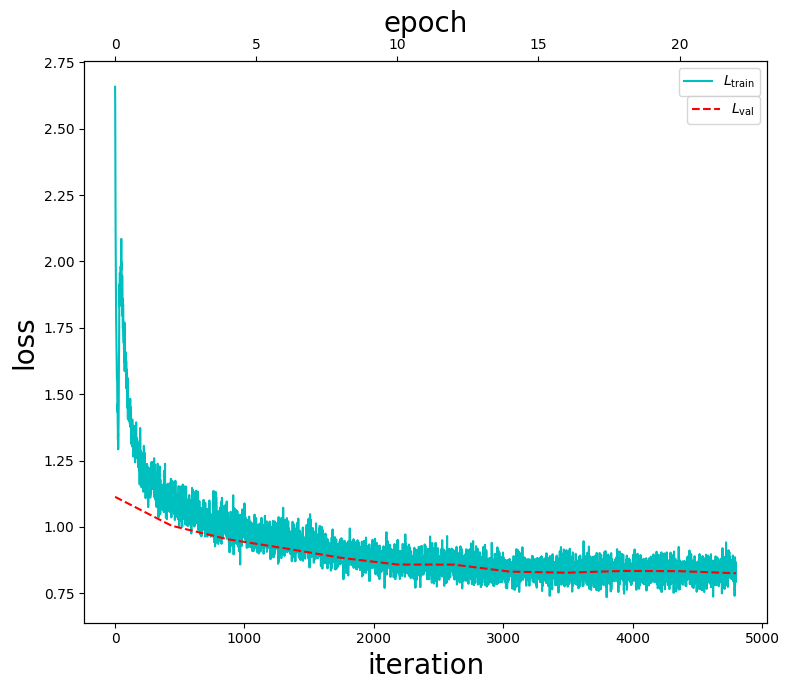

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
x_val = range(0,23,2)

ax.plot(l, 'c', label=r'$L_{\rm{train}}$' )
ax.legend(loc='upper right')
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('loss', fontsize=20)

ax2 = ax.twiny()
ax2.plot(x_val, vl, 'r--', label=r'$L_{\rm{val}}$' )
ax2.set_xlabel('epoch', fontsize=20)
ax2.legend([r'$L_{\rm{val}}$'], loc='upper right', bbox_to_anchor=(1, 0.95))

fig.tight_layout()